In [254]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time


In [255]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [256]:
#pd.set_option('display.max_rows', None)
train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("test.csv")
samples_submission_csv = pd.read_csv("sample_submission.csv")

In [257]:
train_wo_SP = train_csv.drop(['SalePrice'], axis='columns')
#print(train_wo_SP)
# concat train and test features to have the same number of columns one the dummies features appear
all_features = pd.concat([train_wo_SP, test_csv], keys=["train", "test"])
#print(all_features)
# Normalize the numerical features
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# creathe the dummies for train and test set
all_features_dummies = pd.get_dummies(all_features)
#print(all_features_dummies)

# creation of the label of train dataset
train_label1 = train_csv['Id']
train_label2 = train_csv['SalePrice']
train_label = pd.DataFrame(columns = ['Id', 'SalePrice'])
train_label['Id'] = train_label1
train_label['SalePrice'] = train_label2
print(train_label.max())

#Split Data - creation of the Validation dataset
train_data = split_train_valid_data(all_features_dummies.loc['train'])
valid_data = all_features_dummies.loc['train'].iloc[max(train_data.index+1):]

#Split label - creation of the validation labelset
label_train = split_train_valid_data(train_label)
label_valid = train_label.iloc[max(train_data.index+1):]

# creation of the test data set
test_data = all_features_dummies.loc['test']

# creation of an Empty label test
label_test = pd.DataFrame(np.empty((test_data.shape[0],1)))

print('before')

train_data = train_data.astype(np.float32)
valid_data = valid_data.astype(np.float32)
test_data = test_data.astype(np.float32)
print(train_data.shape)
print(valid_data.shape)
print(label_train.shape)
print(label_valid.shape)
print(test_data.shape)
print(label_test.shape)

# remove 'ID' columns - data
train_data = train_data.drop(['Id'], axis=1)
train_data = train_data.fillna(0)
valid_data = valid_data.drop(['Id'],axis=1)
valid_data = valid_data.fillna(0)
test_data = test_data.drop(['Id'], axis=1)
test_data = test_data.fillna(0)

# remove 'ID' column - label
label_train = label_train.drop(['Id'], axis=1)
label_valid = label_valid.drop(['Id'], axis=1)

print('after')
print(train_data.shape)
print(valid_data.shape)
print(label_train.shape)
print(label_valid.shape)
print(test_data.shape)
print(label_test.shape)


Id             1460
SalePrice    755000
dtype: int64
before
(1021, 289)
(439, 289)
(1021, 2)
(439, 2)
(1459, 289)
(1459, 1)
after
(1021, 288)
(439, 288)
(1021, 1)
(439, 1)
(1459, 288)
(1459, 1)


In [258]:
# Data preparation

class PrepareData(Dataset):

    def __init__(self, In, Out):
        if not torch.is_tensor(In):
            In = In.to_numpy()
            self.In = torch.from_numpy(In)
        if not torch.is_tensor(Out):
            Out = Out.to_numpy()
            self.Out = torch.from_numpy(Out)

    def __len__(self):
        return len(self.In)

    def __getitem__(self, idx):
        return self.In[idx], self.Out[idx]
        


data_dataset = {x: PrepareData(In=train_data if x == 'train'
                               else valid_data if x =='valid'
                               else test_data, 
                               Out=label_train if x == 'train'
                               else label_valid if x == 'valid'
                               else label_test)
                for x in ['train', 'valid', 'test']}

data_loader = {x: torch.utils.data.DataLoader(data_dataset[x], batch_size = 10,  shuffle=False) 
               for x in ['train', 'valid', 'test']}

In [259]:
print('TRAINING')
img, lab_target = data_dataset['train'].__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image at the first row: ', type(img))
print('image size at the first row: {}'.format(img.size()))
print('\nTarget at the first row: ', lab_target)
print('Target format at the first row: {}'.format(lab_target))
print('Target format at the first row: {}'.format(lab_target.shape))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

images, labels_target = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('\nTargett type on batch size')
print('Target type on batch size = {}'.format(type(labels_target)))
print('Target shape on batch size = ', labels_target.shape)

TRAINING
DATASET
image at the first row:  torch.Size([288])
image at the first row:  <class 'torch.Tensor'>
image size at the first row: torch.Size([288])

Target at the first row:  tensor([208500])
Target format at the first row: tensor([208500])
Target format at the first row: torch.Size([1])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([10, 288])

Targett type on batch size
Target type on batch size = <class 'torch.Tensor'>
Target shape on batch size =  torch.Size([10, 1])


In [260]:
class CustomDataset(Dataset):
    def __init__(self, csv_file_data, csv_file_test, id_col, target_col, data='train'):
        self.data_train= pd.read_csv(csv_file_data)
        self.data_test = pd.read_csv(csv_file_test)
        self.id        = id_col
        self.target    = target_col
        self.data = data

    def __len__(self):
        if self.data == 'train':
            return len(self.data_train)
        else:
            return len(self.data_test)

    def __getitem__(self, idx):
        # remove the target column
        train_wo_SP = self.data_train.drop(self.target, axis='columns')
        # concat train and test features to have the same number of columns one the dummies features appear
        all_features = pd.concat([train_wo_SP, self.data_test], keys=["train", "test"])
        # Normalize the numerical features
        numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
        all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
        # creathe the dummies for train and test set
        all_features_dummies = pd.get_dummies(all_features)
        
        # creation of the label of train dataset
        train_label1 = train_csv['Id']
        train_label2 = train_csv['SalePrice']
        train_label = pd.DataFrame(columns = ['Id', 'SalePrice'])
        train_label['Id'] = train_label1
        train_label['SalePrice'] = train_label2

        #Split Data - creation of the Validation dataset
        train_data = split_train_valid_data(all_features_dummies.loc['train'])
        valid_data = all_features_dummies.loc['train'].iloc[max(train_data.index+1):]
        #Split label - creation of the validation labelset
        label_train = split_train_valid_data(train_label)
        label_valid = train_label.iloc[max(train_data.index+1):]
         
        # creation of the test data set
        test_data = all_features_dummies.loc['test']
        
        # creation of an Empty label test
        label_test = pd.DataFrame(np.empty((test_data.shape[0],1)))
        
        # remove 'ID' columns - data
        train_data = train_data.drop(['Id'], axis=1)
        valid_data = valid_data.drop(['Id'],axis=1)
        test_data = test_data.drop(['Id'], axis=1)
        
        # remove 'ID' column - label
        label_train = label_train.drop(['Id'], axis=1)
        label_valid = label_valid.drop(['Id'], axis=1)
            
        # data preparation
        if self.data == 'train':
            use_data = train_data.to_numpy()
            use_data = torch.from_numpy(use_data)
        elif self.data == 'valid':
            use_data = valid_data.to_numpy()
            use_data = torch.from_numpy(use_data)
        elif self.data == 'test':
            use_data = test_data.to_numpy()
            use_data = torch.from_numpy(use_data)
            
        # label preparation
        if self.data == 'train':
            label_data = label_train.to_numpy()
            label_data = torch.from_numpy(label_data)
        elif self.data == 'valid':
            label_data = label_valid.to_numpy()
            label_data = torch.from_numpy(label_data)
        elif self.data == 'test':
            label_data = label_test.to_numpy()
            label_data = torch.from_numpy(label_data)
        
        return use_data, label_data

params = {
    'id_col':'Id',  
    'target_col': ['SalePrice'],
}

In [261]:
data_dataset2 = {x: CustomDataset(csv_file_data="train.csv" , 
                                   csv_file_test="test.csv", 
                                   **params, 
                                   data='train' if x == 'train'
                                   else 'valid' if x =='valid'
                                   else 'test')
                for x in ['train', 'valid', 'test']}

data_loader2 = {x: torch.utils.data.DataLoader(data_dataset2[x], batch_size = 10,  shuffle=False) 
               for x in ['train', 'valid', 'test']}

In [262]:
print('TRAINING')
img, lab_target = data_dataset2['train'].__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image at the first row: ', type(img))
print('image size at the first row: {}'.format(img.size()))
print('\nTarget at the first row: ', lab_target)
print('Target format at the first row: {}'.format(lab_target))
print('Target format at the first row: {}'.format(lab_target.shape))


print()
print('Train Loader type')
train_iter = iter(data_loader2['train'])
print(type(train_iter))

images, labels_target = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('\nTargett type on batch size')
print('Target type on batch size = {}'.format(type(labels_target)))
print('Target shape on batch size = ', labels_target.shape)

TRAINING
DATASET
image at the first row:  torch.Size([1021, 288])
image at the first row:  <class 'torch.Tensor'>
image size at the first row: torch.Size([1021, 288])

Target at the first row:  tensor([[208500],
        [181500],
        [223500],
        ...,
        [160000],
        [213490],
        [176000]])
Target format at the first row: tensor([[208500],
        [181500],
        [223500],
        ...,
        [160000],
        [213490],
        [176000]])
Target format at the first row: torch.Size([1021, 1])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([10, 1021, 288])

Targett type on batch size
Target type on batch size = <class 'torch.Tensor'>
Target shape on batch size =  torch.Size([10, 1021, 1])


In [263]:
for idx, (data, target) in enumerate(data_loader['train']):
    print(target)
    next

tensor([[208500],
        [181500],
        [223500],
        [140000],
        [250000],
        [143000],
        [307000],
        [200000],
        [129900],
        [118000]])
tensor([[129500],
        [345000],
        [144000],
        [279500],
        [157000],
        [132000],
        [149000],
        [ 90000],
        [159000],
        [139000]])
tensor([[325300],
        [139400],
        [230000],
        [129900],
        [154000],
        [256300],
        [134800],
        [306000],
        [207500],
        [ 68500]])
tensor([[ 40000],
        [149350],
        [179900],
        [165500],
        [277500],
        [309000],
        [145000],
        [153000],
        [109000],
        [ 82000]])
tensor([[160000],
        [170000],
        [144000],
        [130250],
        [141000],
        [319900],
        [239686],
        [249700],
        [113000],
        [127000]])
tensor([[177000],
        [114500],
        [110000],
        [385000],
        [130000],
     

tensor([[157000],
        [187500],
        [178000],
        [118500],
        [100000],
        [328900],
        [145000],
        [135500],
        [268000],
        [149500]])
tensor([[122900],
        [172500],
        [154500],
        [165000],
        [118858],
        [140000],
        [106500],
        [142953],
        [611657],
        [135000]])
tensor([[110000],
        [153000],
        [180000],
        [240000],
        [125500],
        [128000],
        [255000],
        [250000],
        [131000],
        [174000]])
tensor([[154300],
        [143500],
        [ 88000],
        [145000],
        [173733],
        [ 75000],
        [ 35311],
        [135000],
        [238000],
        [176500]])
tensor([[201000],
        [145900],
        [169990],
        [193000],
        [207500],
        [175000],
        [285000],
        [176000],
        [236500],
        [222000]])
tensor([[201000],
        [117500],
        [320000],
        [190000],
        [242000],
     

'Model creation

In [264]:
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # linear layer (330 -> 500)
        self.fc1 = nn.Linear(288, 500)
        
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        
        # linear layer (250 -> 125)
        self.fc3 = nn.Linear(250, 125)
        
        # linear layer (125 -> 1)
        self.fc4 = nn.Linear(125, 755001)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.175)
        
        # LogSoftmax
        self.LSM = nn.LogSoftmax()
    
    def forward(self, x):
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h3
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h4
        x = self.fc4(x)
        x = self.LSM(x)

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_HR = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_patho.cuda()

In [265]:
model_HR

Net(
  (fc1): Linear(in_features=288, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=125, bias=True)
  (fc4): Linear(in_features=125, out_features=755001, bias=True)
  (dropout): Dropout(p=0.175, inplace=False)
  (LSM): LogSoftmax()
)

In [266]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_HR.parameters(), lr=0.01, momentum = 0.9)

VERSION = 'Test_version'

In [267]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    train_class = []
    valid_class = []
    epoch_class = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        LR = 0.01
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()

            output = model(data)
            
            loss = criterion(output, target.squeeze(-1))
            
            loss.backward()
            
            optimizer.step()

            train_loss += loss.item()*data.size(0)
            
        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target.squeeze(-1))
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        
        
        valid_loss = valid_loss/len(loaders['valid'].sampler)
        
        if valid_loss < 0.35 and valid_loss > 0.15:
            LR=0.005
        elif valid_loss < 0.15:
            LR=0.001
        
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            LR
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), VERSION))
                 )
            valid_loss_min = valid_loss
        
        # store class data
        train_class.append(train_loss)
        valid_class.append(valid_loss)
        epoch_class.append(epoch)
    
    plt.plot(epoch_class, train_class, 'g', label='Training loss')
    plt.plot(epoch_class, valid_class, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # return trained model
    return model

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 13.518797 	Validation Loss: 13.482560 	Time since the beginning 2.0 min 	Learning rate: 0.010000 
Validation loss decreased (inf --> 13.482560).  Saving model ...
Epoch: 2 	Training Loss: 12.993568 	Validation Loss: 11.360754 	Time since the beginning 3.9 min 	Learning rate: 0.010000 
Validation loss decreased (13.482560 --> 11.360754).  Saving model ...
Epoch: 3 	Training Loss: 10.173163 	Validation Loss: 9.870750 	Time since the beginning 6.0 min 	Learning rate: 0.010000 
Validation loss decreased (11.360754 --> 9.870750).  Saving model ...
Epoch: 4 	Training Loss: 8.880490 	Validation Loss: 9.396496 	Time since the beginning 7.9 min 	Learning rate: 0.010000 
Validation loss decreased (9.870750 --> 9.396496).  Saving model ...
Epoch: 5 	Training Loss: 7.911295 	Validation Loss: 9.231639 	Time since the beginning 9.8 min 	Learning rate: 0.010000 
Validation loss decreased (9.396496 --> 9.231639).  Saving model ...
Epoch: 6 	Training Loss: 7.266767 	Validation 

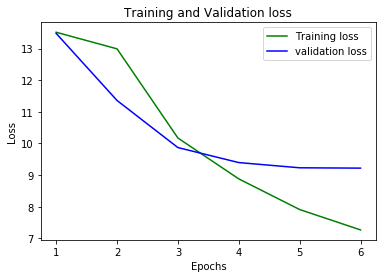

In [268]:
model_res = train(6, data_loader, model_HR, optimizer, criterion)

In [269]:
# test


In [278]:
dataiter_test = iter(data_loader['test'])
print('data_iter\n',dataiter_test)
data_test = dataiter_test.next()
data_test_data = data_test[0]
print('image test data',data_test_data)
data_test_label = data_test[1]
print(data_test_label)

model_test = model_HR
model_test.load_state_dict(torch.load(VERSION))
model_test = model_test.eval()


out_fwd = model_test.forward(data_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
print(probs.max())
print(probs.mi)

data_iter
image test data tensor([[-8.7347e-01,  4.5810e-01,  1.8434e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-8.7347e-01,  5.0093e-01,  5.1970e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [ 6.7320e-02,  2.0108e-01,  4.6429e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        ...,
        [ 6.7320e-02, -2.7011e-01, -2.2393e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-8.7347e-01,  6.7228e-01,  9.9986e-04,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-8.7347e-01,  2.9737e-02, -2.2418e-01,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00]])
tensor([[ 0.0000e+00],
        [4.9407e-324],
        [9.8813e-324],
        [1.4822e-323],
        [1.9763e-323],
        [2.4703e-323],
        [2.9644e-323],
        [3.4585e-323],
        [3.9525e-323],
        [4.4466e-323]], dtype=torch.float64)
Result preditcion model on dataset:
 tensor([[-16.5751, -17.0310, -15.6306,  ..., -17.8134

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
